In [ ]:
#execute just the first time to move scripts and dataset from input to output
import sys
from shutil import copytree, copyfile
sys.path.append( "/kaggle/input/cityscapes" )

src_datasets='/kaggle/input/cityscapes/datasets/'
dst_datasets='/kaggle/working/datasets/'
copytree(src_datasets, dst_datasets)

src_datasets='/kaggle/input/cityscapes/Cityscapes_v2.py'
dst_datasets='/kaggle/working/datasets/Cityscapes_v2.py'
copyfile(src_datasets, dst_datasets)

src_datasets='/kaggle/input/cityscapes/deeplab_resnet_pretrained_imagenet.pth'
dst_datasets='/kaggle/working/deeplab_resnet_pretrained_imagenet.pth'
copyfile(src_datasets, dst_datasets)

src_models='/kaggle/input/cityscapes/models'
dst_models='/kaggle/working/models/'
copytree(src_models, dst_models)

copyfile(src = "/kaggle/input/cityscapes/utils.py", dst = "/kaggle/working/utils.py")

'/kaggle/working/utils.py'

In [ ]:
#this one you need it always
sys.path.append('/kaggle/input/cityscapes/datasets/')

In [ ]:
# TODO: Define here your training and validation loops.

import torch.nn.functional as F
from Cityscapes_v2 import CityScapes
from torch.utils.data import DataLoader
import torch
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from models.deeplabv2.deeplabv2 import Bottleneck
from models.deeplabv2.deeplabv2 import ResNetMulti
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from utils import poly_lr_scheduler

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=19):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                #print("true class size",true_class.shape)
                #print("true label size",true_label.shape)
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def convert_tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0)
    return image

def train(model, optimizer, train_loader, criterion):
    model.train()
    running_loss = 0.0
    total = 0
    iou_score=0
    accuracy=0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.float()
        targets = targets.squeeze(dim=1)

        #Compute prediction and loss
        outputs,_,_ = model(inputs)
        loss = loss_fn(outputs.to(dtype=torch.float32), targets.to(dtype=torch.int64))
        iou_score += mIoU(outputs.to(device), targets.to(device))
        accuracy += pixel_accuracy(outputs.to(device), targets.to(device))

        #BackPropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)

    train_loss = running_loss / len(train_loader)
    iou_score = iou_score / len(train_loader)
    accuracy = accuracy / len(train_loader)
    return train_loss,iou_score,accuracy

# Test loop
def test(model, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    iou_score=0.0
    accuracy=0.0
    with torch.no_grad():
        for batch_idx,(inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float()
            targets = targets.int()

            #Compute prediction and loss
            outputs = model(inputs)
            loss = loss_fn(outputs.to(dtype=torch.float32), targets.squeeze(dim=1).to(dtype=torch.int64))
            iou_score += mIoU(outputs.to(device), targets.to(device))
            accuracy += pixel_accuracy(outputs.to(device), targets.to(device))
            test_loss += loss.item()

    test_loss = test_loss / len(test_loader)
    iou_score = iou_score / len(test_loader)
    accuracy = accuracy / len(test_loader)
    #test_accuracy = 100. * correct / total
    return test_loss,iou_score,accuracy

dataset_path='/kaggle/input/cityscapes/Cityscapes/Cityscapes/Cityspaces/'
image_train=dataset_path+'images/train'
sem_map_train=dataset_path+'gtFine/train'
image_val=dataset_path+'images/val'
sem_map_val=dataset_path+'gtFine/val'

resize_transform = transforms.Resize(interpolation=transforms.InterpolationMode.NEAREST_EXACT,size = (512,1024))

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
# Define dataset and loader
cityscapes_train = CityScapes(annotations_dir=sem_map_train, images_dir=image_train,transform=resize_transform)
cityscapes_val = CityScapes(annotations_dir=sem_map_val, images_dir=image_val,transform=resize_transform)

train_loader = DataLoader(cityscapes_train, batch_size=1, shuffle=True)
val_loader = DataLoader(cityscapes_val, batch_size=1, shuffle=True)

training dataset contains 1572 images
validation dataset contains 500 images


/kaggle/input/cityscapes/Cityscapes_v2.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotation= torch.tensor(self.transform(annotation),dtype=torch.uint8)


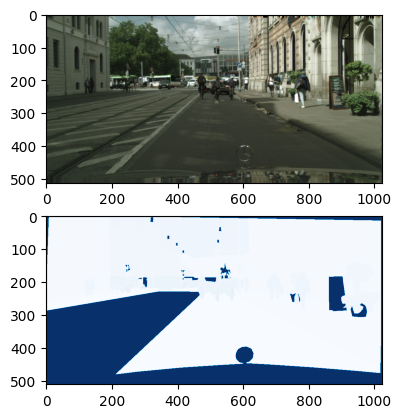

In [ ]:
print(f'training dataset contains {cityscapes_train.__len__()} images')
print(f'validation dataset contains {cityscapes_val.__len__()} images')

index = 564
# print('Image path: \n'f'{cityscapes_train.map_index_to_image[index]}')
# print('Map path: \n'f'{cityscapes_train.map_index_to_annotation[index]}')
image, sem_map = cityscapes_train.__getitem__(index)
sem_map.size()
fig, axes = plt.subplots(2, 1)
image_transpose = convert_tensor_to_image(image)
map_transpose = convert_tensor_to_image(sem_map)
axes[0].imshow(image_transpose)
axes[1].imshow(map_transpose, cmap='Blues')
plt.show()

In [ ]:
#pretrained model
# Define the model and move it to the device
model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes=19)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
poly_lr_scheduler(optimizer, 0.01, 1, lr_decay_iter=1, max_iter=300, power=0.9)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=255)

# Freeze parameters except ClassifierModule
for param in model.get_1x_lr_params_no_scale():
    param.requires_grad = False

In [ ]:
from torchinfo import summary
summary(model, input_size=(1,3,512,1024), col_names=["output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
ResNetMulti                              [1, 19, 512, 1024]        --                        Partial
├─Conv2d: 1-1                            [1, 64, 256, 512]         (9,408)                   False
├─BatchNorm2d: 1-2                       [1, 64, 256, 512]         (128)                     False
├─ReLU: 1-3                              [1, 64, 256, 512]         --                        --
├─MaxPool2d: 1-4                         [1, 64, 129, 257]         --                        --
├─Sequential: 1-5                        [1, 256, 129, 257]        --                        False
│    └─Bottleneck: 2-1                   [1, 256, 129, 257]        --                        False
│    │    └─Conv2d: 3-1                  [1, 64, 129, 257]         (4,096)                   False
│    │    └─BatchNorm2d: 3-2             [1, 64, 129, 257]         (128)                     False
│    │    

In [ ]:
!pip install -U fvcore

In [ ]:
# FLOPS
from fvcore.nn import FlopCountAnalysis, flop_count_table

plot_loader = DataLoader(cityscapes_train, batch_size=1, shuffle=True)
(input,output) = next(iter(plot_loader))
height = 512
width = 1024

flops = FlopCountAnalysis(model, input.to(device,dtype=torch.float32))
print(flop_count_table(flops))

In [ ]:
# Latency and FPS
import time
import numpy as np
net = model
net.eval()
fps_loader = DataLoader(cityscapes_train, batch_size=1, shuffle=True)
(inputs, annotations) = next(iter(fps_loader))
inputs=inputs.to(device,dtype=torch.float32)
iterations=1000
latency=np.empty(0)
FPS=np.empty(0)
for i in range(iterations):
    start=time.time()
    output=net(inputs)
    end=time.time()
    latency_i=end-start
    #print(latency_i)
    latency=np.append(latency,latency_i)
    FPS_i=float(1/latency_i)
    FPS=np.append(FPS,FPS_i)
meanLatency=np.mean(latency)
stdLatency=np.std(latency)
meanFPS=np.mean(FPS)
stdFPS=np.std(FPS)


In [ ]:
print (f"mean latency: {meanLatency} seconds")
print(f"std latency: {stdLatency} seconds")
print (f"mean FPS: {meanFPS} fps")
print(f"std FPS: {stdFPS} fps")

In [ ]:
# Train the model

epoch_beginning=1
epochs = 50+epoch_beginning
train_iou_list=[]
train_acc_list=[]
train_loss_list=[]
test_iou_list=[]
test_acc_list=[]
test_loss_list=[]

for epoch in range(epoch_beginning,epochs):
    train_loss,train_iou,train_acc=train(model, optimizer, train_loader, loss_fn)
    train_iou_list.append(train_iou)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    #save model
    if epoch%5 == 0 or epoch==epochs:
        model_name = f"deeplabv2_bs1_epoch{epoch}_weights.pth"
        torch.save(model.state_dict(), model_name)

    test_loss,test_iou,test_acc = test(model, val_loader, loss_fn)
    test_iou_list.append(test_iou)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    print(f"Epoch: {epoch}")
    print(f"- Test Acc: {test_acc:.3f}")
    print(f"- Test Loss: {test_loss:.3f}")
    print(f"- Test mIoU: {test_iou:.3f}")
    print("__________________________")

In [ ]:
# Resume training from epoch 40
last_epoch = 40
path_weights="/kaggle/input/cityscapes/deeplabv2_bs1_epoch40_weights.pth"
model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes=19)
model.to(device)
model.load_state_dict(torch.load(path_weights))
epoch_beginning = last_epoch+1
epochs = 50+1

train_iou_list=[]
train_acc_list=[]
train_loss_list=[]
test_iou_list=[]
test_acc_list=[]
test_loss_list=[]

for epoch in range(epoch_beginning,epochs):
    train_loss,train_iou,train_acc=train(model, optimizer, train_loader, loss_fn)
    train_iou_list.append(train_iou)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    #save model
    if epoch%5 == 0 or epoch==epochs:
        model_name = f"deeplabv2_bs1_epoch{epoch}_weights.pth"
        torch.save(model.state_dict(), model_name)

    test_loss,test_iou,test_acc = test(model, val_loader, loss_fn)
    test_iou_list.append(test_iou)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    print(f"Epoch: {epoch}")
    print(f"- Test Acc: {test_acc:.3f}")
    print(f"- Test Loss: {test_loss:.3f}")
    print(f"- Test mIoU: {test_iou:.3f}")
    print("__________________________")

/kaggle/input/cityscapes/Cityscapes_v2.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotation= torch.tensor(self.transform(annotation),dtype=torch.uint8)


Epoch: 41
- Test Acc: 0.467
- Test Loss: 172.959
- Test mIoU: 0.134
__________________________
Epoch: 42
- Test Acc: 0.469
- Test Loss: 178.306
- Test mIoU: 0.136
__________________________
Epoch: 43
- Test Acc: 0.472
- Test Loss: 175.328
- Test mIoU: 0.137
__________________________
Epoch: 44
- Test Acc: 0.460
- Test Loss: 184.064
- Test mIoU: 0.132
__________________________
Epoch: 45
- Test Acc: 0.453
- Test Loss: 211.181
- Test mIoU: 0.131
__________________________
Epoch: 46
- Test Acc: 0.445
- Test Loss: 204.901
- Test mIoU: 0.129
__________________________
Epoch: 47
- Test Acc: 0.450
- Test Loss: 199.809
- Test mIoU: 0.130
__________________________
Epoch: 48
- Test Acc: 0.446
- Test Loss: 209.342
- Test mIoU: 0.126
__________________________
Epoch: 49
- Test Acc: 0.449
- Test Loss: 194.377
- Test mIoU: 0.132
__________________________
Epoch: 50
- Test Acc: 0.455
- Test Loss: 210.448
- Test mIoU: 0.130
__________________________


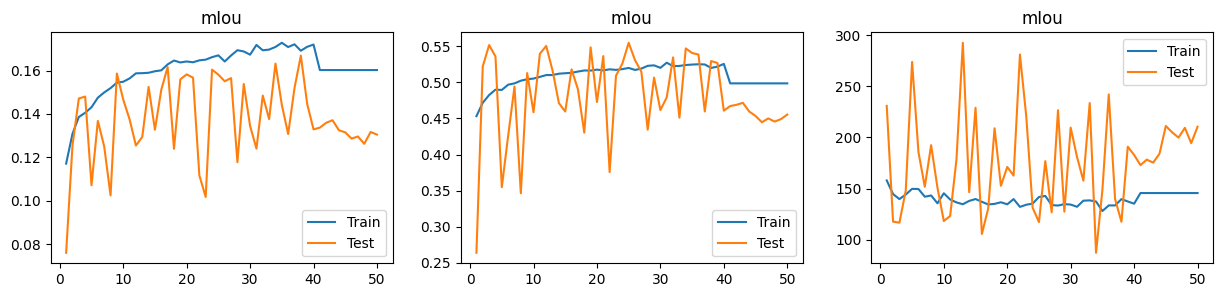

In [ ]:
metrics = np.stack(arrays=[train_iou_val ,train_acc_val , train_loss_val, test_iou_val, test_acc_val, test_loss_val], axis=0)

# Plot Graphs
names = ["mIou", "Accuracy", "Loss"]
plotted = 0
plt.figure(figsize=(15,3))
for i in range(len(names)):
    plotted += 1
    plt.subplot(1,3,plotted)
    plt.plot(range(1, epochs), metrics[i], label="Train")
    plt.plot(range(1, epochs), metrics[i+len(names)], label="Test")
    plt.title(f"{names[i]}")
    plt.legend()
plt.show()